In [1]:
# Public score 4.47675
import tensorflow as tf
import numpy as np
import dataset as ds
from random import shuffle
trainToTestRatio = 0.8

dataset = np.load('faceFeatures_2140_normalized_labels_as_coord_full_data.npz')
samples = dataset['data'].shape[0]
sampleSize = dataset['data'].shape[1]
coordsCount = dataset['y'].shape[1]
splitIdx = int(samples*trainToTestRatio)
trainData = dataset['data'][:splitIdx]
trainY = dataset['y'][:splitIdx]
testData = dataset['data'][splitIdx:]
testY = dataset['y'][splitIdx:]

resultDataset = ds.TestsetDB()

In [2]:
class Batcher:
    def __init__(self, data, labels):
        self.maxSize = data.shape[0]
        self.data = data
        self.labels = labels
        self.ni = 0
        self.idxs = list(range(self.maxSize))
        shuffle(self.idxs)
    
    def nextBatch(self, size):
        assert(size <= self.maxSize)
        
        n = self.ni
        self.ni += size
        
        if self.ni > self.maxSize:
            tailIdxs = self.idxs[n:self.maxSize]
            headIdxs = self.idxs[:self.ni-self.maxSize]
            d = np.vstack([self.data[tailIdxs], self.data[headIdxs]])
            l = np.vstack([self.labels[tailIdxs], self.labels[headIdxs]])
            self.ni = 0
            shuffle(self.idxs)
            return d, l
        else:
            return self.data[self.idxs[n:self.ni]], self.labels[self.idxs[n:self.ni]]

In [3]:
outputSize = coordsCount
x=tf.placeholder(tf.float32,shape=[None,sampleSize])
y_=tf.placeholder(tf.float32,shape=[None,outputSize])
x_96_96=tf.reshape(x,[-1,96,96,1])
w_conv1=tf.Variable(tf.truncated_normal([3,3,1,32],stddev=0.1))
b_conv1=tf.Variable(tf.constant(0.1,shape=[32]))
h_conv1=tf.nn.relu(tf.nn.conv2d(x_96_96,w_conv1,strides=[1,1,1,1],padding='SAME')+b_conv1)
h_max_pool1=tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

w_conv2=tf.Variable(tf.truncated_normal([3,3,32,64],stddev=0.1))
b_conv2=tf.Variable(tf.constant(0.1,shape=[64]))
h_conv2=tf.nn.relu(tf.nn.conv2d(h_max_pool1,w_conv2,strides=[1,1,1,1],padding='SAME')+b_conv2)
h_max_pool2=tf.nn.max_pool(h_conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

w_conv3=tf.Variable(tf.truncated_normal([2,2,64,128],stddev=0.1))
b_conv3=tf.Variable(tf.constant(0.1,shape=[128]))
h_conv3=tf.nn.relu(tf.nn.conv2d(h_max_pool2,w_conv3,strides=[1,1,1,1],padding='SAME')+b_conv3)
h_max_pool3=tf.nn.max_pool(h_conv3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

h_pool_flat=tf.reshape(h_max_pool3,[-1,12*12*128])

keep_prob = tf.placeholder(tf.float32)

w_fc1=tf.Variable(tf.truncated_normal([12*12*128,500],stddev=0.1))
b_fc1=tf.Variable(tf.constant(0.1,shape=[500]))
h_fc1=tf.nn.relu(tf.matmul(h_pool_flat,w_fc1)+b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

w_fc2=tf.Variable(tf.truncated_normal([500,500],stddev=0.1))
b_fc2=tf.Variable(tf.constant(0.1,shape=[500]))
h_fc2=tf.nn.relu(tf.matmul(h_fc1_drop,w_fc2)+b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

w_fc3=tf.Variable(tf.truncated_normal([500,30],stddev=0.1))
b_fc3=tf.Variable(tf.constant(0.1,shape=[30]))


y=tf.matmul(h_fc2_drop,w_fc3)+b_fc3

In [4]:
saver = tf.train.Saver()

In [5]:
#lossFunc = tf.nn.l2_loss(y - y_)
lossFunc = tf.sqrt(tf.reduce_mean((y - y_)**2))

train_step = tf.train.AdamOptimizer(1e-4).minimize(lossFunc)

In [8]:
epohs = 100001
early_stopping_max=7
early_stopping_num=early_stopping_max
win_score=float('inf')


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

trainLoss = []
testLoss = []
batcher=Batcher(trainData,trainY)
#test_batcher=Batcher(testData,testY)


for i in range(epohs):
    tD,tY=batcher.nextBatch(100)
    
    #evalY=y.eval(feed_dict={x:trainData, keep_prob: 1.0},session=sess)
    #evalY[~np.isnan(tY)]=tY[~np.isnan(tY)]
    if i % 1000 == 0:
        #tstD,tstY=batcher.nextBatch(100)
        train = lossFunc.eval(feed_dict={x:tD, y_:tY, keep_prob: 1.0}, session=sess)
        #evalTestY=y.eval(feed_dict={x:tstD, keep_prob: 1.0},session=sess)
        #evalTestY[~np.isnan(tstY)]=tstY[~np.isnan(tstY)]
        test = lossFunc.eval(feed_dict={x:testData, y_:testY, keep_prob: 1.0}, session=sess)
        trainLoss+=[train]
        testLoss+=[test]
        if test<win_score:
            saver.save(sess,'win_sess')
            early_stopping_num=early_stopping_max
        else:
            early_stopping_num-=1
            if early_stopping_num<=0:
                break      
        print('train:', train, 'test:', test)
    train_step.run(feed_dict={x:tD, y_:tY, keep_prob:0.5}, session=sess)

train: 7.56305 test: 7.47665
train: 0.062225 test: 0.0875496
train: 0.0557521 test: 0.0871625
train: 0.0593399 test: 0.0871467
train: 0.0639097 test: 0.0873492
train: 0.0630186 test: 0.0876552
train: 0.0594743 test: 0.0881371
train: 0.0588086 test: 0.0887325
train: 0.0626869 test: 0.0892404
train: 0.0589057 test: 0.0898862
train: 0.0577497 test: 0.0904736
train: 0.0566451 test: 0.0912848
train: 0.0614522 test: 0.0917814
train: 0.0639176 test: 0.0924412
train: 0.053301 test: 0.0929739
train: 0.0673848 test: 0.0934399
train: 0.0598166 test: 0.0939567
train: 0.0604514 test: 0.094302
train: 0.0602271 test: 0.0945706
train: 0.0612258 test: 0.0948845
train: 0.058528 test: 0.0950161
train: 0.0599397 test: 0.095224
train: 0.0625179 test: 0.0952692
train: 0.0601754 test: 0.0953846
train: 0.0600037 test: 0.095609
train: 0.0612565 test: 0.0955855
train: 0.0644589 test: 0.0957365
train: 0.0600801 test: 0.0958247
train: 0.0610721 test: 0.0957168
train: 0.0592518 test: 0.0959077
train: 0.0614854 tes

In [6]:
#saver.save(sess, 'cnn-3conv-3fc.ckpt')
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
saver.restore(sess, 'cnn-3conv-3fc.ckpt')

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def addFeatures(ax, features, isFill = True):
    for i in range(0, 30, 2):
        x = (features[i] + 1) * (96 / 2.0)
        y = (features[i + 1] + 1) * (96 / 2.0)
        ax.add_patch(patches.Circle((x,y),1, fill = isFill))
    
def showFace(data, features, expectedFeatures = None):
    fig,ax = plt.subplots()
    addFeatures(ax, features)
    if not expectedFeatures is None:
        addFeatures(ax, expectedFeatures, False)
    plt.imshow(data.reshape(96, 96), cmap = 'gray')

In [8]:
tData=trainData[:10]
evalResult=y.eval(feed_dict={x:tData, keep_prob:1.0}, session=sess)
testResult = lambda idx : showFace(tData[idx], evalResult[idx])

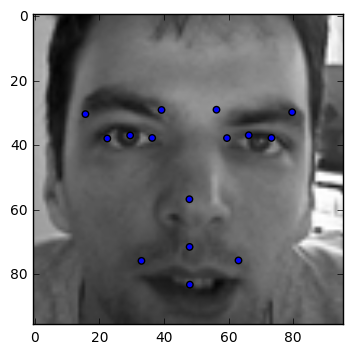

In [9]:
testResult(5)

In [18]:
resultData = np.zeros((resultDataset.rows(), sampleSize), np.float32)
for face in resultDataset.getFaces():
    resultData[face.id - 1, :] = face.image.reshape((sampleSize,)).astype(np.float32) / 255.0

for idx in range(resultData.shape[0]):
    face = resultDataset.getFace(idx + 1)
    resultY = y.eval(feed_dict={x:resultData[idx:(idx+1), :], keep_prob:1.0}, session=sess)
    for featureId in ds.allFeatures:
        fX = (resultY[0, featureId * 2] + 1) * (96 / 2.0)
        fY = (resultY[0, featureId * 2 + 1] + 1) * (96 / 2.0)
        if fX > 96:
            fX = 96
        if fY > 96:
            fY = 96
        if fX < 0:
            fX = 0
        if fY < 0:
            fY = 0
        face.setFeaturePosition(featureId, (fX, fY))
resultDataset.write('test_results_convnet2.csv')

In [1]:
def showTestFace(face):
    fig,ax = plt.subplots()
    for key, value in face.features.items():
        ax.add_patch(patches.Circle(value,1))
    ax.imshow(face.image, cmap = 'gray')
    
showTestFace(resultDataset.getFace(4))

NameError: name 'resultDataset' is not defined